In [5]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import time
from numdifftools import Hessian

In [6]:
arr_hub = np.loadtxt('Hz_all.dat')
z_obs = arr_hub[:,0]
hub_obs = arr_hub[:,1]
error_obs = arr_hub[:,2]

In [7]:
# cosmological parameters :
H0 = 70
Om = 0.3
Or = 1e-4
Ol = 1.0 - Om - Or

# parametrization 
def w_CPL(z, w0, wa):
    return w0 + wa * (z / (1 + z))
# Hubble with the CPL parametrization
def Hubble_CPL(z, w0, wa):
    w_z = w_CPL(z, w0, wa)
    exponent = 3 * (1 + w0 + wa) * np.log(1 + z) - 3 * wa * (z / (1 + z))
    return H0 * np.sqrt(Om * (1 + z)**3 + Or * (1 + z)**4 + Ol * np.exp(exponent))


In [8]:
# Define chi-squared function
def chi_squared(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL):
    H_theory = np.array([Hubble_CPL(z, w0, wa) for z in z_obs])
    return np.sum(((hub_obs - H_theory) / error_obs) ** 2)

# Define log-likelihood
def log_likelihood(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL):
    chi2 = chi_squared(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL)
    return -0.5 * chi2

In [9]:
# Define parameter space
w0_ini, w0_fin = -2,-0.5
wa_ini, wa_fin = -2, 3

# Define parameter space
w0_vals = np.linspace(w0_ini, w0_fin, 100)
wa_vals = np.linspace(wa_ini, wa_fin, 100)
W0, Wa = np.meshgrid(w0_vals, wa_vals)

# Compute log-likelihood using vectorized operations
start_grid = time.time()
log_L = np.array([[log_likelihood(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL) 
                    for w0 in w0_vals] for wa in wa_vals])

end_grid = time.time()
# Convert log-likelihood to likelihood for plotting
L = np.exp(log_L - np.max(log_L))  # Normalize for better numerical stability

#best-fit parameters
max_index = np.unravel_index(np.argmax(L), L.shape)
w0_best, wa_best = W0[max_index], Wa[max_index]
print(f"Best-fit parameters: w0 = {w0_best:.4f}, wa = {wa_best:.4f}")

Best-fit parameters: w0 = -1.1970, wa = 0.6263


In [10]:
# Genetic Algorithm Implementation
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define individual initialization
def init_individual():
    return creator.Individual([random.uniform(w0_ini, w0_fin), random.uniform(wa_ini, wa_fin)])

# Define fitness function for GA
def fitness_function(ind):
    w0, wa = ind
    return (np.exp(log_likelihood(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL)),)  # Maximize likelihood


toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

start_ga = time.time()
population = toolbox.population(n=100)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=False)
end_ga = time.time()
ga_time = end_ga - start_ga


best_individual = tools.selBest(population, k=1)[0]
w0_best_ga, wa_best_ga = best_individual
print(f"GA Best-fit: w0 = {w0_best_ga:.4f}, wa = {wa_best_ga:.4f}")


GA Best-fit: w0 = -1.2076, wa = 0.6885


/tmp/ipykernel_214894/248651008.py:7: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(w0_best_ga, wa_best_ga, color='cyan', edgecolor='black', marker='x', s=100,


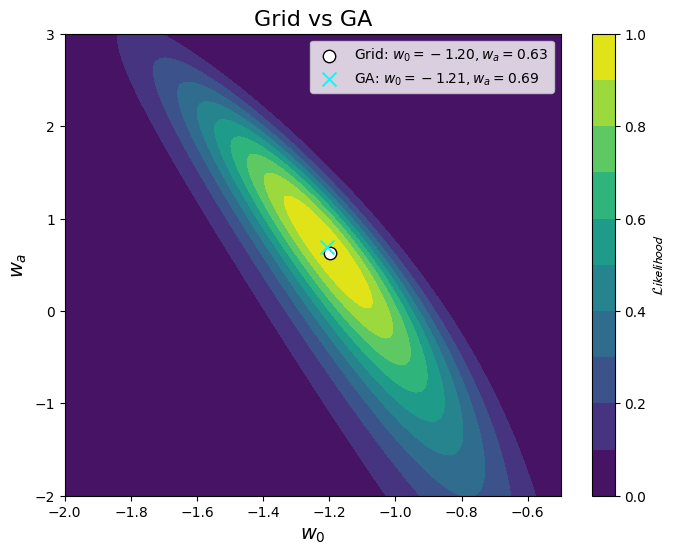

In [11]:
# Plot contour map
plt.figure(figsize=(8, 6))
contour = plt.contourf(W0, Wa, L, levels=10, cmap='viridis')
plt.colorbar(contour, label='$\mathcal{Likelihood}$')
plt.scatter(w0_best, wa_best, color='white', edgecolor='black', marker='o', s=80, 
            label=f'Grid: $w_0={w0_best:.2f}, w_a={wa_best:.2f}$')
plt.scatter(w0_best_ga, wa_best_ga, color='cyan', edgecolor='black', marker='x', s=100, 
            label=f'GA: $w_0={w0_best_ga:.2f}, w_a={wa_best_ga:.2f}$')


plt.xlabel('$w_0$', fontsize=14)
plt.ylabel('$w_a$', fontsize=14)
plt.title('Grid vs GA', fontsize=16)
plt.legend()
plt.show()


In [12]:
grid_time = end_grid - start_grid
ga_time = end_ga - start_ga

print(f"Execution Time Comparison: Grid Search = {grid_time:.2f} s, GA = {ga_time:.2f} s")

Execution Time Comparison: Grid Search = 1.17 s, GA = 0.43 s


In [13]:
import numdifftools as nd

In [14]:
def log_likelihood(params, z_obs, hub_obs, error_obs, Hubble_CPL):
    """Modified to accept single parameter array for Hessian computation"""
    w0, wa = params
    H_theory = np.array([Hubble_CPL(z, w0, wa) for z in z_obs])
    chi2 = np.sum(((hub_obs - H_theory) / error_obs) ** 2)
    return -0.5 * chi2

def compute_hessian(w0_best, wa_best, z_obs, hub_obs, error_obs, Hubble_CPL):
    """Compute Hessian matrix at best-fit parameters"""
    hessian_func = Hessian(lambda params: log_likelihood(params, z_obs, hub_obs, error_obs, Hubble_CPL))
    return hessian_func([w0_best, wa_best])


log_L = np.array([[log_likelihood([w0, wa], z_obs, hub_obs, error_obs, Hubble_CPL) 
                 for w0 in w0_vals] for wa in wa_vals])

L = np.exp(log_L - np.max(log_L))  

max_index = np.unravel_index(np.argmax(L), L.shape)
w0_best_grid, wa_best_grid = W0[max_index], Wa[max_index]
print(f"Grid Search Best-fit: w0 = {w0_best_grid:.4f}, wa = {wa_best_grid:.4f}")

# Compute Hessian and covariance matrix

hessian_matrix = compute_hessian(w0_best_grid, wa_best_grid, z_obs, hub_obs, error_obs, Hubble_CPL)
covariance_matrix = np.linalg.inv(-hessian_matrix)  # Invert negative Hessian to get covariance matrix
    
print("Hessian Matrix:\n", hessian_matrix)
print("Covariance Matrix:\n", covariance_matrix)
    
    # Compute parameter uncertainties
w0_err, wa_err = np.sqrt(np.diag(covariance_matrix))
print(f"Parameter uncertainties: w0_err = +/-{w0_err:.4f}, wa_err =+/-{wa_err:.4f}")
    



Grid Search Best-fit: w0 = -1.1970, wa = 0.6263
Hessian Matrix:
 [[-68.23124966 -13.55878819]
 [-13.55878819  -3.25379655]]
Covariance Matrix:
 [[ 0.08524516 -0.3552223 ]
 [-0.3552223   1.7875684 ]]
Parameter uncertainties: w0_err = +/-0.2920, wa_err =+/-1.3370


In [15]:

eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
print("\nEigenanalysis Results:")
print("Eigenvalues:", eigenvalues)
print("Eigenvectors (columns):\n", eigenvectors)
    
# Parameter uncertainties from covariance
w0_err, wa_err = np.sqrt(np.diag(covariance_matrix))
print(f"\nParameter uncertainties:")
print(f"w0 = {w0_best_grid:.4f} +/- {w0_err:.4f}")
print(f"wa = {wa_best_grid:.4f} +/- {wa_err:.4f}")
    



Eigenanalysis Results:
Eigenvalues: [0.01409502 1.85871854]
Eigenvectors (columns):
 [[-0.98052454  0.19639662]
 [-0.19639662 -0.98052454]]

Parameter uncertainties:
w0 = -1.1970 +/- 0.2920
wa = 0.6263 +/- 1.3370


In [16]:
# Physical interpretation
print("\nPhysical Interpretation:")
if eigenvalues[0] > eigenvalues[1]:
    primary_dir = eigenvectors[:,0]
    econdary_dir = eigenvectors[:,1]
else:
    primary_dir = eigenvectors[:,1]
    secondary_dir = eigenvectors[:,0]
    
print(f"Primary constraint direction: {primary_dir}")
print(f"Secondary constraint direction: {secondary_dir}")
    



Physical Interpretation:
Primary constraint direction: [ 0.19639662 -0.98052454]
Secondary constraint direction: [-0.98052454 -0.19639662]



Correlation coefficient between w0 and wa: -0.910


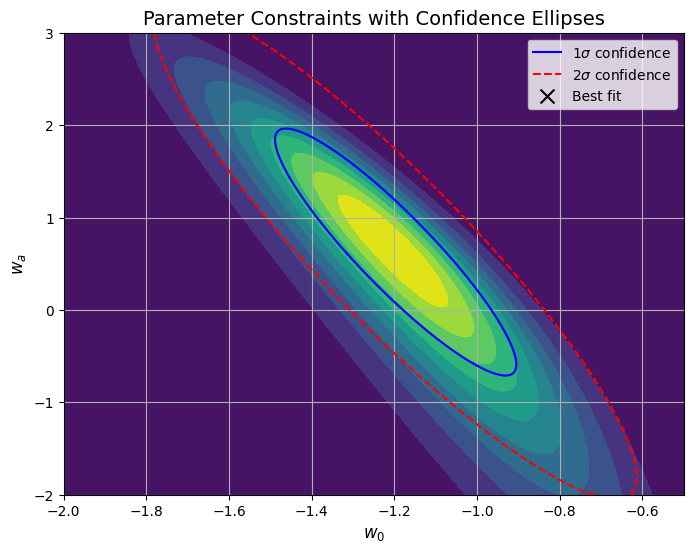

In [18]:
# Correlation coefficient
correlation = covariance_matrix[0,1]/(w0_err*wa_err)
print(f"\nCorrelation coefficient between w0 and wa: {correlation:.3f}")
    
# Visualize the covariance ellipse
plt.figure(figsize=(8,6))
theta = np.linspace(0, 2*np.pi, 100)
    
# 1-sigma ellipse
a, b = np.sqrt(eigenvalues)
ellipse_x = w0_best_grid + a*np.cos(theta)*eigenvectors[0,0] + b*np.sin(theta)*eigenvectors[0,1]
ellipse_y = wa_best_grid + a*np.cos(theta)*eigenvectors[1,0] + b*np.sin(theta)*eigenvectors[1,1]
    
plt.plot(ellipse_x, ellipse_y, 'b-', label='1$\sigma$ confidence')
    
# 2-sigma ellipse
ellipse_x2 = w0_best_grid + 2*a*np.cos(theta)*eigenvectors[0,0] + 2*b*np.sin(theta)*eigenvectors[0,1]
ellipse_y2 = wa_best_grid + 2*a*np.cos(theta)*eigenvectors[1,0] + 2*b*np.sin(theta)*eigenvectors[1,1]
    
plt.plot(ellipse_x2, ellipse_y2, 'r--', label='2$\sigma$ confidence')
plt.scatter(w0_best_grid, wa_best_grid, c='k', marker='x', s=100, label='Best fit')
    
plt.contourf(W0, Wa, L, levels=10, cmap='viridis')
plt.xlabel('$w_0$', fontsize=12)
plt.ylabel('$w_a$', fontsize=12)
plt.ylim(-2,3)
plt.title('Parameter Constraints with Confidence Ellipses', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
    


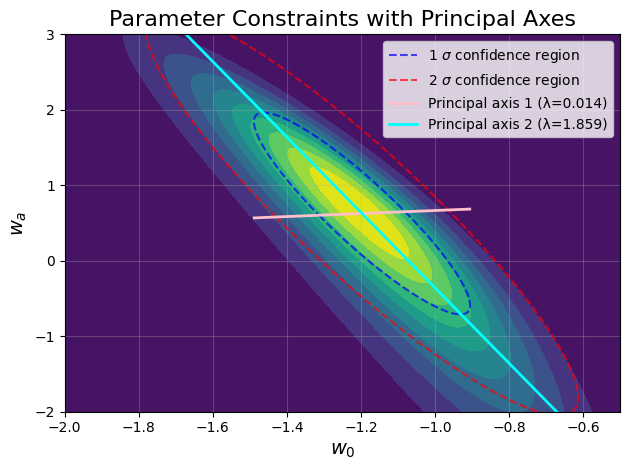

In [19]:
for n_sigma in [1, 2]:
    a = n_sigma * np.sqrt(eigenvalues[0])
    b = n_sigma * np.sqrt(eigenvalues[1])
    ellipse_x = w0_best_grid + a * np.cos(theta) * eigenvectors[0,0] + b * np.sin(theta) * eigenvectors[0,1]
    ellipse_y = wa_best_grid + a * np.cos(theta) * eigenvectors[1,0] + b * np.sin(theta) * eigenvectors[1,1]
    plt.plot(ellipse_x, ellipse_y, '--', alpha=0.7, 
    label=f'{n_sigma} $\\sigma$ confidence region', 
    color=['blue', 'red'][n_sigma-1])

# Plot principal axes (eigenvectors)
scale = 2.5  # Scaling factor for axis visibility
colors = ['pink', 'cyan']  
    
for i, (eig_val, eig_vec) in enumerate(zip(eigenvalues, eigenvectors.T)):
        # Calculate axis endpoints
    axis_length = scale * np.sqrt(eig_val)
    x_end = w0_best_grid + axis_length * eig_vec[0]
    y_end = wa_best_grid + axis_length * eig_vec[1]
    x_start = w0_best_grid - axis_length * eig_vec[0]
    y_start = wa_best_grid - axis_length * eig_vec[1]
        
        # Plot axis line
    plt.plot([x_start, x_end], [y_start, y_end], lw=2, color=colors[i],
                label=f'Principal axis {i+1} (λ={eig_val:.3f})')
        
        # Add arrowhead
plt.annotate('', xy=(x_end, y_end), xytext=(w0_best_grid, wa_best_grid),
             arrowprops=dict(arrowstyle="->", color=colors[i], lw=2))




plt.xlabel('$w_0$', fontsize=14)
plt.ylabel('$w_a$', fontsize=14)
plt.title('Parameter Constraints with Principal Axes', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
    

axis_pad = 0.2
x_extent = scale * max(np.sqrt(eigenvalues) * np.abs(eigenvectors[0,:]))
y_extent = scale * max(np.sqrt(eigenvalues) * np.abs(eigenvectors[1,:]))
plt.xlim(w0_best_grid - x_extent - axis_pad, w0_best_grid + x_extent + axis_pad)
plt.ylim(wa_best_grid - y_extent - axis_pad, wa_best_grid + y_extent + axis_pad)
plt.scatter(w0_best_grid, wa_best_grid, c='black', marker='x', s=100, label='Best fit')
plt.contourf(W0, Wa, L, levels=10, cmap='viridis')
plt.tight_layout()
plt.ylim(-2,3)
plt.xlim(-2,-0.5)
plt.show()

